In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import os
import cv2
import glob
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

In [3]:
import os
import cv2
import itertools
import numpy as np
import pandas as pd
from keras.metrics import Precision, Recall, AUC
from sklearn.metrics import accuracy_score, classification_report
from time import perf_counter
from sklearn.model_selection import StratifiedShuffleSplit


In [6]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: architgupta16
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


100%|██████████| 34.1M/34.1M [00:03<00:00, 10.2MB/s]


In [7]:
img_size = (76, 208)

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

In [8]:
dataset_dir = '/content/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

categories = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']

data = []
labels = []
for category in categories:
    path = os.path.join(dataset_dir, 'train', category)
    class_num = categories.index(category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img_array = preprocess_image(img_path)
            data.append([img_array,class_num])
            labels.append(class_num)
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

for category in categories:
    path = os.path.join(dataset_dir, 'test', category)
    class_num = categories.index(category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img_array = preprocess_image(img_path)
            data.append([img_array,class_num])
            labels.append(class_num)

        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

np.random.shuffle(data)


In [9]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

y = to_categorical(y, num_classes=len(categories))

n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)

for train_index, test_index in stratified_split.split(X,y):
  X_t, X_test = X[train_index], X[test_index]
  y_t, y_test = y[train_index], y[test_index]

In [10]:
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [11]:
from collections import Counter

train_class_counts = Counter(np.argmax(y_train, axis=1))

val_class_counts = Counter(np.argmax(y_val, axis=1))

test_class_counts = Counter(np.argmax(y_test, axis=1))

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 0: 1433 samples
Class 1: 574 samples
Class 3: 2048 samples
Class 2: 41 samples

Validation Set Class Counts:
Class 0: 359 samples
Class 3: 512 samples
Class 1: 143 samples
Class 2: 10 samples

Test Set Class Counts:
Class 0: 448 samples
Class 3: 640 samples
Class 1: 179 samples
Class 2: 13 samples


In [ ]:
import random
random.seed(20)

In [ ]:
X_train[0].shape

(208, 76, 1)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (208, 76, 1)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes: MildDemented, ModerateDemented, NonDemented, VeryMildDemented

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 74, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 103, 37, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 103, 37, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 35, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 17, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 50, 17, 64)        0

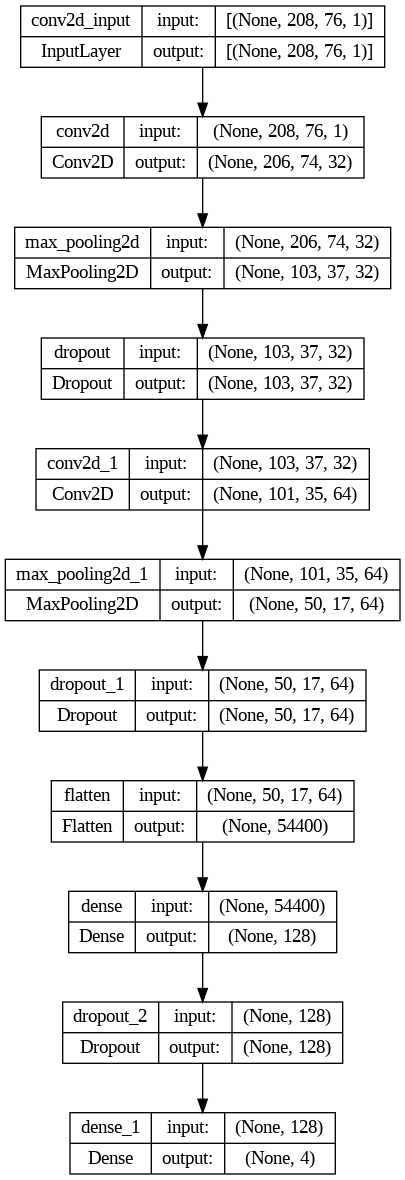

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision = Precision()
    recall = Recall()
    f1_score = f1_score
    specificity = specificity
    sensitivity = sensitivity
    mcc = mcc
    auc = AUC()

    return (
        precision,
        recall,
        f1_score,
        specificity,
        sensitivity,
        mcc,
        auc,
    )

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()])

In [ ]:
initial_learning_rate=0.0009

def lr_scheduler(epoch, lr):
    if epoch < 7:
      return lr
    else:
      return lr * 0.95

lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
class_weights = {0:0.26,1:0.29,2:0.24,3:0.21}

In [ ]:

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

optimizer_ad = Adam(learning_rate=initial_learning_rate)

start_time = perf_counter()

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weights,
    callbacks=[lr_callback, early_stopping_callback]
)
end_time = perf_counter()

Epoch 1/20
128/128 [==============================] - 12s 26ms/step - loss: 0.2700 - accuracy: 0.4641 - precision: 0.5255 - recall: 0.1638 - f1_score: 0.2356 - specificity: 0.9507 - sensitivity: 0.1638 - mcc: 0.1810 - auc: 0.7711 - val_loss: 1.1800 - val_accuracy: 0.5312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_specificity: 1.0000 - val_sensitivity: 0.0000e+00 - val_mcc: 0.0000e+00 - val_auc: 0.8036 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 3s 21ms/step - loss: 0.2502 - accuracy: 0.5176 - precision: 0.6391 - recall: 0.2192 - f1_score: 0.3080 - specificity: 0.9587 - sensitivity: 0.2192 - mcc: 0.2688 - auc: 0.8046 - val_loss: 0.9766 - val_accuracy: 0.5586 - val_precision: 0.8868 - val_recall: 0.1836 - val_f1_score: 0.3012 - val_specificity: 0.9922 - val_sensitivity: 0.1836 - val_mcc: 0.3401 - val_auc: 0.8390 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 3s 22ms/step - loss: 0.2321 - accuracy: 0.551

In [ ]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 1 minutes, 3 seconds, 983 milliseconds


In [ ]:
_ = model.evaluate(X_test, y_test, verbose=2)

40/40 - 0s - loss: 0.2946 - accuracy: 0.8945 - precision: 0.9045 - recall: 0.8734 - f1_score: 0.8884 - specificity: 0.9693 - sensitivity: 0.8734 - mcc: 0.8527 - auc: 0.9847 - 213ms/epoch - 5ms/step


In [ ]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

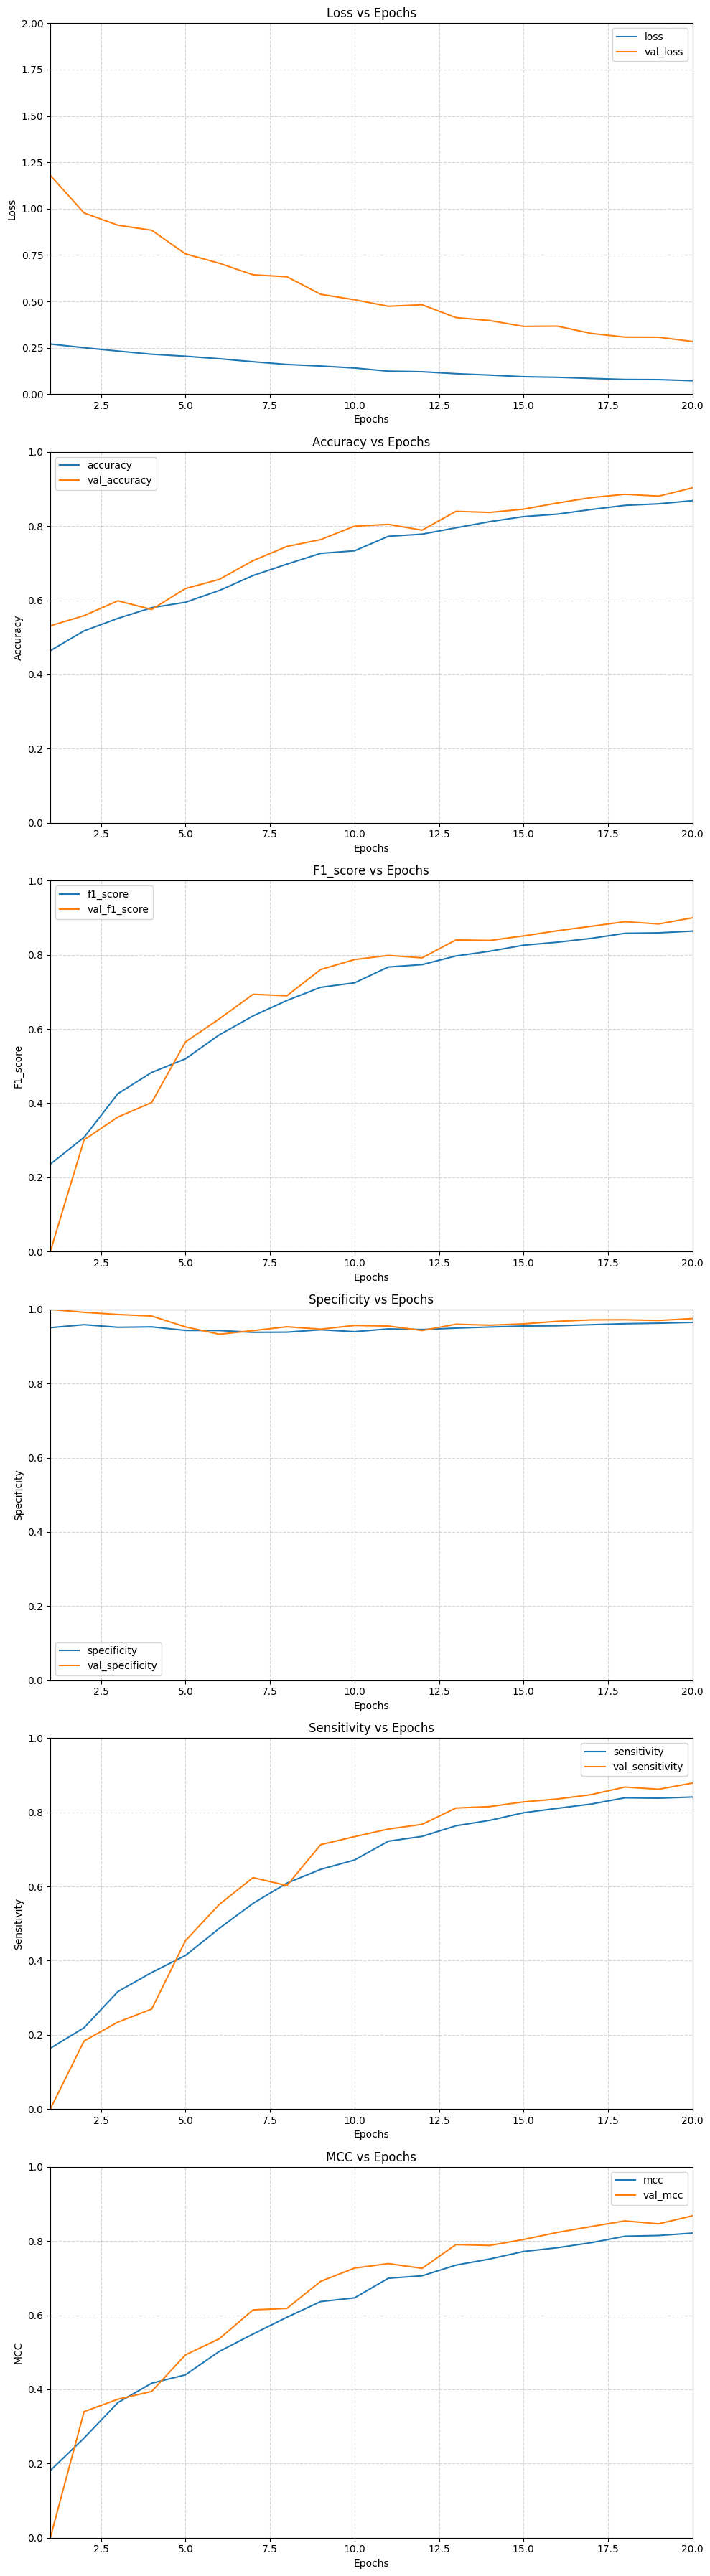

In [ ]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

40/40 [==============================] - 0s 5ms/step
                  precision    recall  f1-score   support

    MildDemented       0.86      0.90      0.87       448
ModerateDemented       0.91      0.87      0.89       179
     NonDemented       1.00      0.62      0.76        13
VeryMildDemented       0.92      0.91      0.91       640

        accuracy                           0.89      1280
       macro avg       0.92      0.82      0.86      1280
    weighted avg       0.90      0.89      0.89      1280



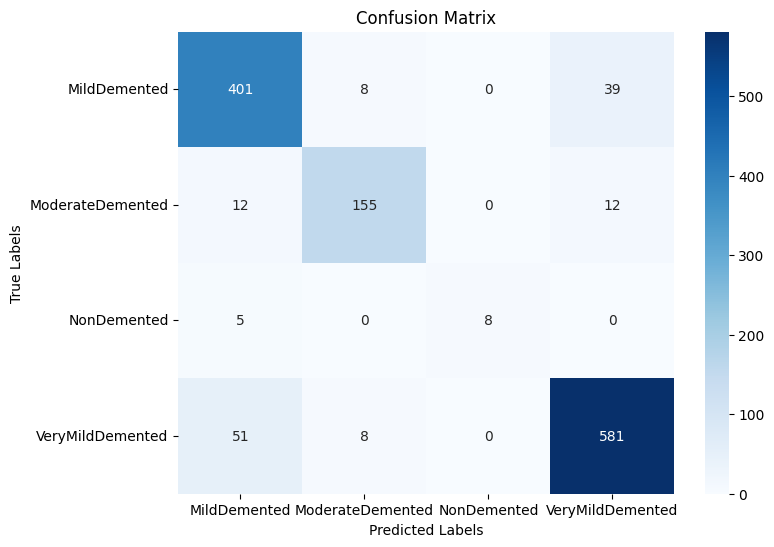

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming y_test is your one-hot encoded test labels
y_test_classes = np.argmax(y_test, axis=1)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
